# Extreme rain by country

Calculate the total and % area per country.



In [1]:
%matplotlib inline

In [2]:
from pathlib import Path

import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns
from tqdm.notebook import tqdm
from config import DATA_SRC, WEATHER_SRC, POP_DATA_SRC
from util import area_of_pixel

In [3]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (5,2.5)
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.titlesize'] = 'medium'

In [4]:
MAX_YEAR = 2019
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet' / 'extreme_rain'

RESULTS_FOLDER = Path('./results/extreme rain')
RESULTS_FOLDER.mkdir(parents=True, exist_ok=True)

In [5]:
MAP_PROJECTION = ccrs.EckertIII()

In [6]:
COUNTRY_RASTER_FILES = DATA_SRC/ 'lancet/population/country_codes_30min_era_compat.nc'
COUNTRY_ID_LOOKUP = DATA_SRC/ 'lancet/population/gpwv4/gpw_v4_national_identifier_lookup.txt'

In [7]:
COUNTRIES_RASTER = xr.open_dataset(COUNTRY_RASTER_FILES).load()

In [8]:
COUNTRIES_LOOKUP = pd.read_csv(COUNTRY_ID_LOOKUP,sep='\t')

In [9]:
land_mask = (COUNTRIES_RASTER.country_codes < 9999)

# Load the excess extreme events (>$\mu$+2$\sigma$)

In [10]:
events_select_extreme = xr.open_dataarray(INTERMEDIATE_RESULTS_FOLDER / 'excess_extreme_events.nc')

In [11]:
events_select_extreme = events_select_extreme.drop('surface').drop('number')

## Calculate areas

In [12]:
areas = area_of_pixel(0.5, events_select_extreme.latitude.values) / (1000*1000)
areas = xr.DataArray(areas, dims=['latitude'], coords={'latitude': events_select_extreme.latitude})

In [13]:
total_land_area = (land_mask * areas).sum()

Checking that the mean of the sum gives the same result as the sum of the mean....

In [15]:
extreme_event_area_ts = (events_select_extreme * areas).sum(dim=['latitude', 'longitude']).compute()

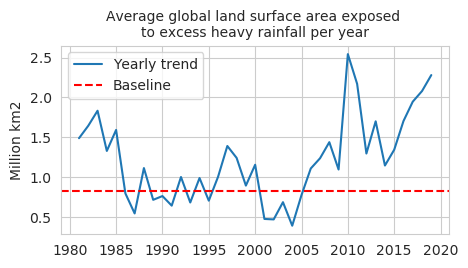

In [16]:
with sns.axes_style('whitegrid'):
    f, ax = plt.subplots()

    # Plot ERA5
    plot_data = (extreme_event_area_ts.sel(year=slice(1981,None)) / 1_000_000)

    baseline = (extreme_event_area_ts.sel(year=slice(REFERENCE_YEAR_START,REFERENCE_YEAR_END)).mean(dim='year')/ 1_000_000)

    plot_data.plot(ax=ax, label='Yearly trend')

    ax.axhline(baseline, color='r', linestyle='--', label='Baseline')

    ax.legend()
    ax.set(
        title='Average global land surface area exposed \nto excess heavy rainfall per year',
        xlabel='',
        ylabel='Million km2'
    )

#     f.savefig(RESULTS_FOLDER / 'area_extreme_rainfall.png')
#     plot_data.drop(['number', 'surface']).to_dataframe('area excess heavy rain million km2').to_excel(RESULTS_FOLDER / 'area_excess_heavy_rain.xlsx')
    
    f.show()


# Apply by country

In [17]:
events_areas = events_select_extreme * areas

In [18]:
total_areas = []
    
for _, row in tqdm(COUNTRIES_LOOKUP.iterrows(), total=len(COUNTRIES_LOOKUP)):
    grid_code = row.GRIDCODE
    country_mask = COUNTRIES_RASTER.country_codes == grid_code
    country_exposures = (events_areas * country_mask).sum(dim=['latitude', 'longitude'])
    
    country_exposures = country_exposures.expand_dims(dim={'country':[row.ISOCODE]})
    total_areas.append(country_exposures)

total_areas = xr.concat(total_areas, dim='country')

In [19]:
# total_areas.to_dataframe()

In [14]:
sphere_areas = COUNTRIES_RASTER.country_codes.astype(bool) * areas

In [21]:
country_areas = []
    
for _, row in tqdm(COUNTRIES_LOOKUP.iterrows(), total=len(COUNTRIES_LOOKUP)):
    grid_code = row.GRIDCODE
    country_mask = COUNTRIES_RASTER.country_codes == grid_code
    country_area = (sphere_areas * country_mask).sum(dim=['latitude', 'longitude'])
    country_area = country_area.expand_dims(dim={'country':[row.ISOCODE]})

    country_areas.append(country_area)

country_areas = xr.concat(country_areas, dim='country')

In [22]:
country_areas_df = country_areas.to_dataframe('percent_area')

In [24]:
country_areas_df.reset_index().to_excel(RESULTS_FOLDER/'country_areas.xlsx', index=False)

In [21]:
percent_areas = []
    
for _, row in tqdm(COUNTRIES_LOOKUP.iterrows(), total=len(COUNTRIES_LOOKUP)):
    grid_code = row.GRIDCODE
    country_mask = COUNTRIES_RASTER.country_codes == grid_code
    country_area = (sphere_areas * country_mask).sum(dim=['latitude', 'longitude'])
    country_exposures = (events_areas * country_mask).sum(dim=['latitude', 'longitude'])
    country_exposures = 100 * country_exposures / country_area
    
    country_exposures = country_exposures.expand_dims(dim={'country':[row.ISOCODE]})
    percent_areas.append(country_exposures)

percent_areas = xr.concat(percent_areas, dim='country')

In [22]:
percent_areas_df = percent_areas.to_dataframe('percent_area')

In [23]:
percent_areas_df.describe()

percent_area
count   9560.000000
mean       0.900188
std        2.744328
min        0.000000
25%        0.000000
50%        0.000000
75%        0.410008
max       30.683751

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2989a99fd0>]],
      dtype=object)

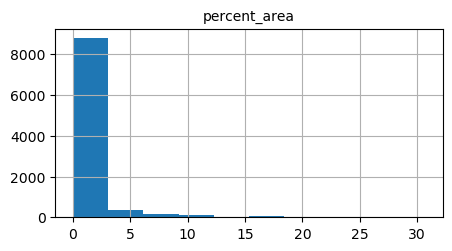

In [25]:
percent_areas_df.hist()

In [86]:
# percent_areas_df.head()

percent_area
country year              
AFG     1980      0.000000
        1981      0.290647
        1982     12.110801
        1983      0.000000
        1984      0.000000

In [37]:
percent_areas_df.reset_index().to_excel(RESULTS_FOLDER/'percent_area_extreme_rain_by_country.xlsx', index=False)

# Choropleth plot

In [30]:
import geopandas as gpd

In [31]:
# COUNTRY_SHAPEFILE = DATA_SRC / 'GIS' / 'world'/ 'ne_50m_admin_0_countries' / 'ne_50m_admin_0_countries.shp'
COUNTRY_SHAPEFILE = '/home/jonathanchambers/Documents/Lancet/Standardisation guidelines/Shapefiles/Detailed/detailed_2013.shp'
country_shapes = gpd.read_file(COUNTRY_SHAPEFILE)

In [32]:
country_shapes = country_shapes.join(percent_areas_df.percent_area.unstack(), on='ISO_3_CODE')

In [33]:
country_shapes = country_shapes.set_index('ISO_3_CODE')
# Drop things without ISO code - mainly channel islands
country_shapes = country_shapes[~country_shapes.index.duplicated()]

In [34]:
# Should work to get the nice projection, but causes erros 
# country_shapes = country_shapes.to_crs('ESRI:54013')

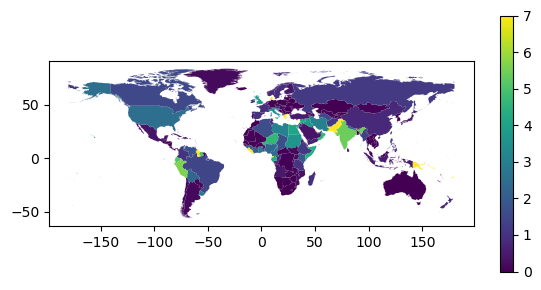

In [35]:
# vmax = country_shapes[2019].quantile(0.95)
vmax = 7
f, ax = plt.subplots(figsize=(6,3), 
#                      subplot_kw=dict(projection=MAP_PROJECTION)
                    )

country_shapes.plot(column=2019, legend=True, vmax=vmax, ax=ax)
plt.tight_layout()